<a href="https://colab.research.google.com/github/katduecker/nma_dl_bearmin/blob/main/bear_min_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mne

     |████████████████████████████████| 6.9 MB 5.0 MB/s 


In [ ]:
# set up
#@title Data retrieval
import os, requests
from scipy import signal
import numpy as np
import mne

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
#@title Data loading
alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 
dat1 = alldat[1][0]

In [ ]:
# Filter

l_cutoff = 0.05 #denoising? 
h_cutoff = 100
ch_names = [f'ecog{n:03}' for n in range(1, dat1['V'].shape[1]+1)] 
sfreq = 1000
ch_types='ecog'
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sfreq)
info['description'] = 'Example pat no 1'

V = dat1['V'].astype('float32')
nt, nchan = V.shape
nstim = len(dat1['t_on'])

# V.transpose() ?
raw = mne.io.RawArray(V.transpose(), info, first_samp=0, copy='auto' )
raw_filtered = raw.filter(l_freq=l_cutoff, h_freq=h_cutoff, method='fir', fir_design='firwin', filter_length='auto', fir_window='hamming', phase='zero', 
           l_trans_bandwidth='auto', h_trans_bandwidth='auto')
V_filtered = raw_filtered['data'][0].transpose()



Creating RawArray with float64 data, n_channels=50, n_times=271360
    Range : 0 ... 271359 =      0.000 ...   271.359 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 66001 samples (66.001 sec)



In [ ]:
# Epoch
trange = np.arange(-200, 400)
ts = dat1['t_on'][:,np.newaxis] + trange
V_epochs = np.reshape(V_filtered[ts, :], (nstim, 600, nchan))

V_epochs = np.transpose(V_epochs, [0, 2, 1])

# extract events
events = np.zeros((dat1['t_on'].shape[0],3), dtype=int)
events[:,0] = dat1['t_on'] 
events[:,1] = dat1['t_off'] 
eve_ids = dat1['stim_id'].copy()
eve_ids[eve_ids <= 50] = 1
eve_ids[eve_ids > 50] = 2
events[:,2] = eve_ids
event_dict = dict(houses=1, faces=2)
epochs = mne.EpochsArray(V_epochs, info, tmin=-0.2, events=events,
                                   event_id=event_dict, baseline=(-0.2, -0.05))

Not setting metadata
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
0 bad epochs dropped


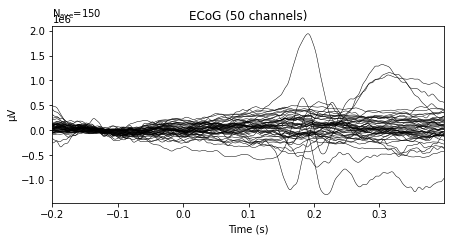

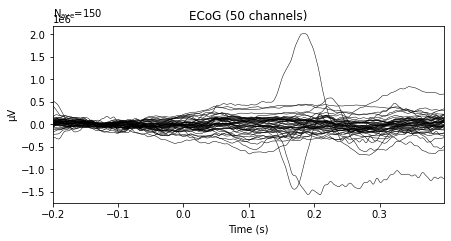

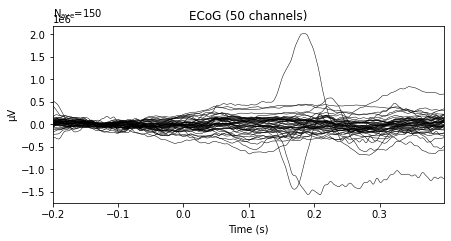

In [ ]:
# plot ERPs

evoked_faces = epochs['faces'].average() #extract evoked data pertaining to faces - just for sanity check!
evoked_houses = epochs['houses'].average() #extract evoked data pertaining to houses - just for sanity check!
evoked_faces.plot() #1st plot
evoked_houses.plot() #2nd an 3rd identical plots

In [ ]:
# TFR with morlet wavelets

from mne.time_frequency import tfr_morlet # Using Morlet wavelet -- seems to work better!

freqs = np.arange(8., 100., 2.)  # define frequencies of interest

powface = tfr_morlet(epochs['faces'], freqs=freqs, n_cycles=2, return_itc=False, average=False)
powhouse = tfr_morlet(epochs['houses'], freqs=freqs, n_cycles=2, return_itc=False, average=False)


Not setting metadata
Not setting metadata


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

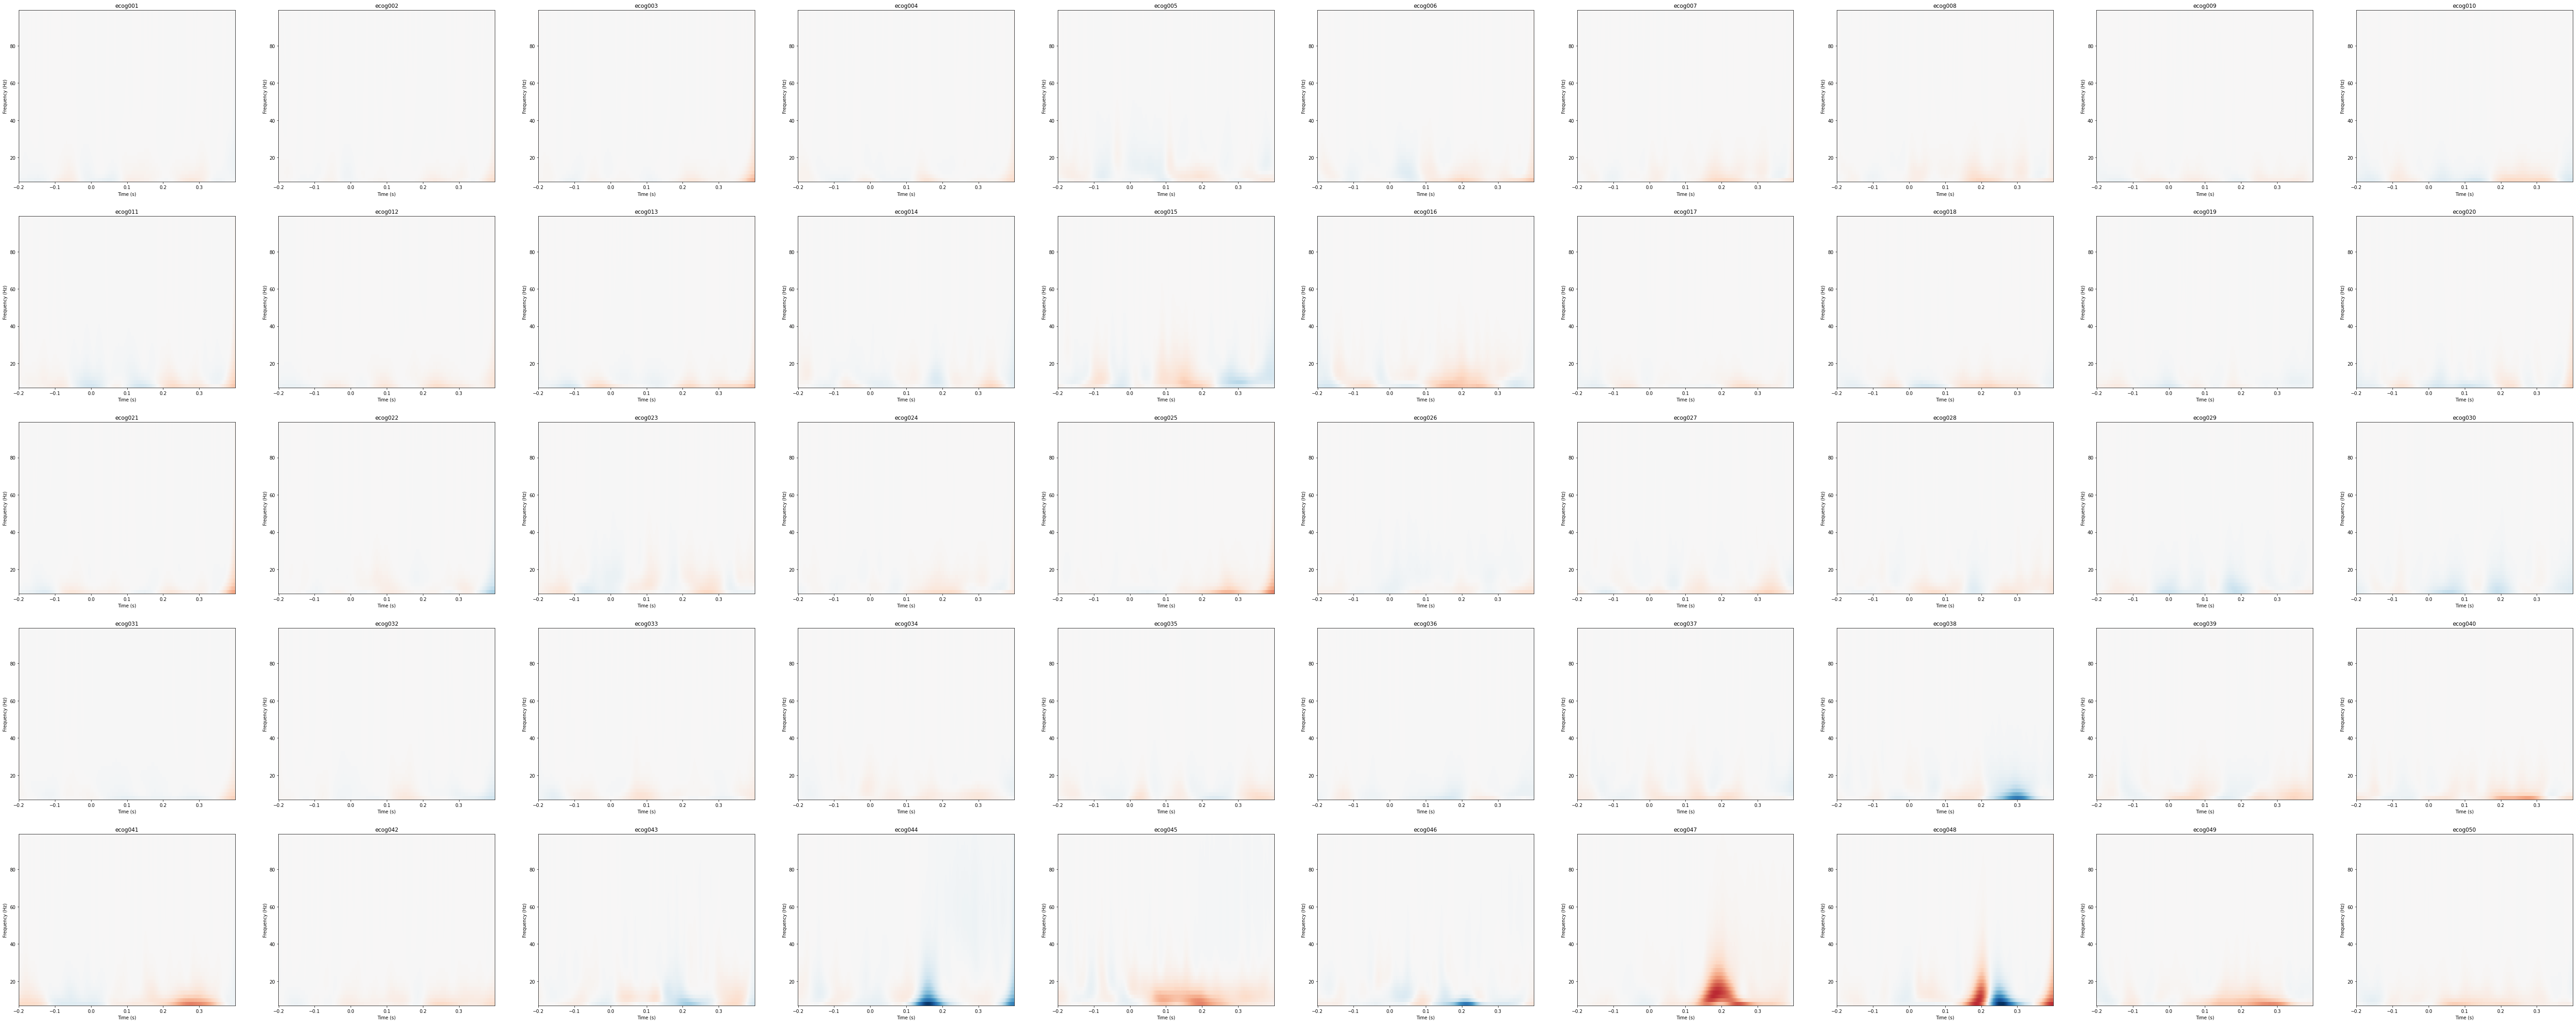

In [ ]:
# contrast TFR face and house to check for differences
import matplotlib.pyplot as plt

powface_avg = powface.average()
powhouse_avg = powhouse.average()

powcontr = powface_avg.copy()
powcontr.data -= powhouse_avg.data

maxpow = np.max(np.abs(powcontr.data))

# plot
fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(100, 40))
a=[]

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        a.append(ax)

for i, ax in enumerate(a):
    powcontr.plot([i], baseline=(-0.2, 0), mode='mean', axes=ax, show=False, colorbar=False,vmin=-maxpow,vmax=maxpow) 
    ax.set_title(powcontr.ch_names[i])

# --> include all channels in classifier

In [ ]:
# log power to normalize
logpowface = powface.copy()
logpowface.data = np.log(logpowface.data)

logpowhouse = powhouse.copy()
logpowhouse.data = np.log(logpowhouse.data)

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

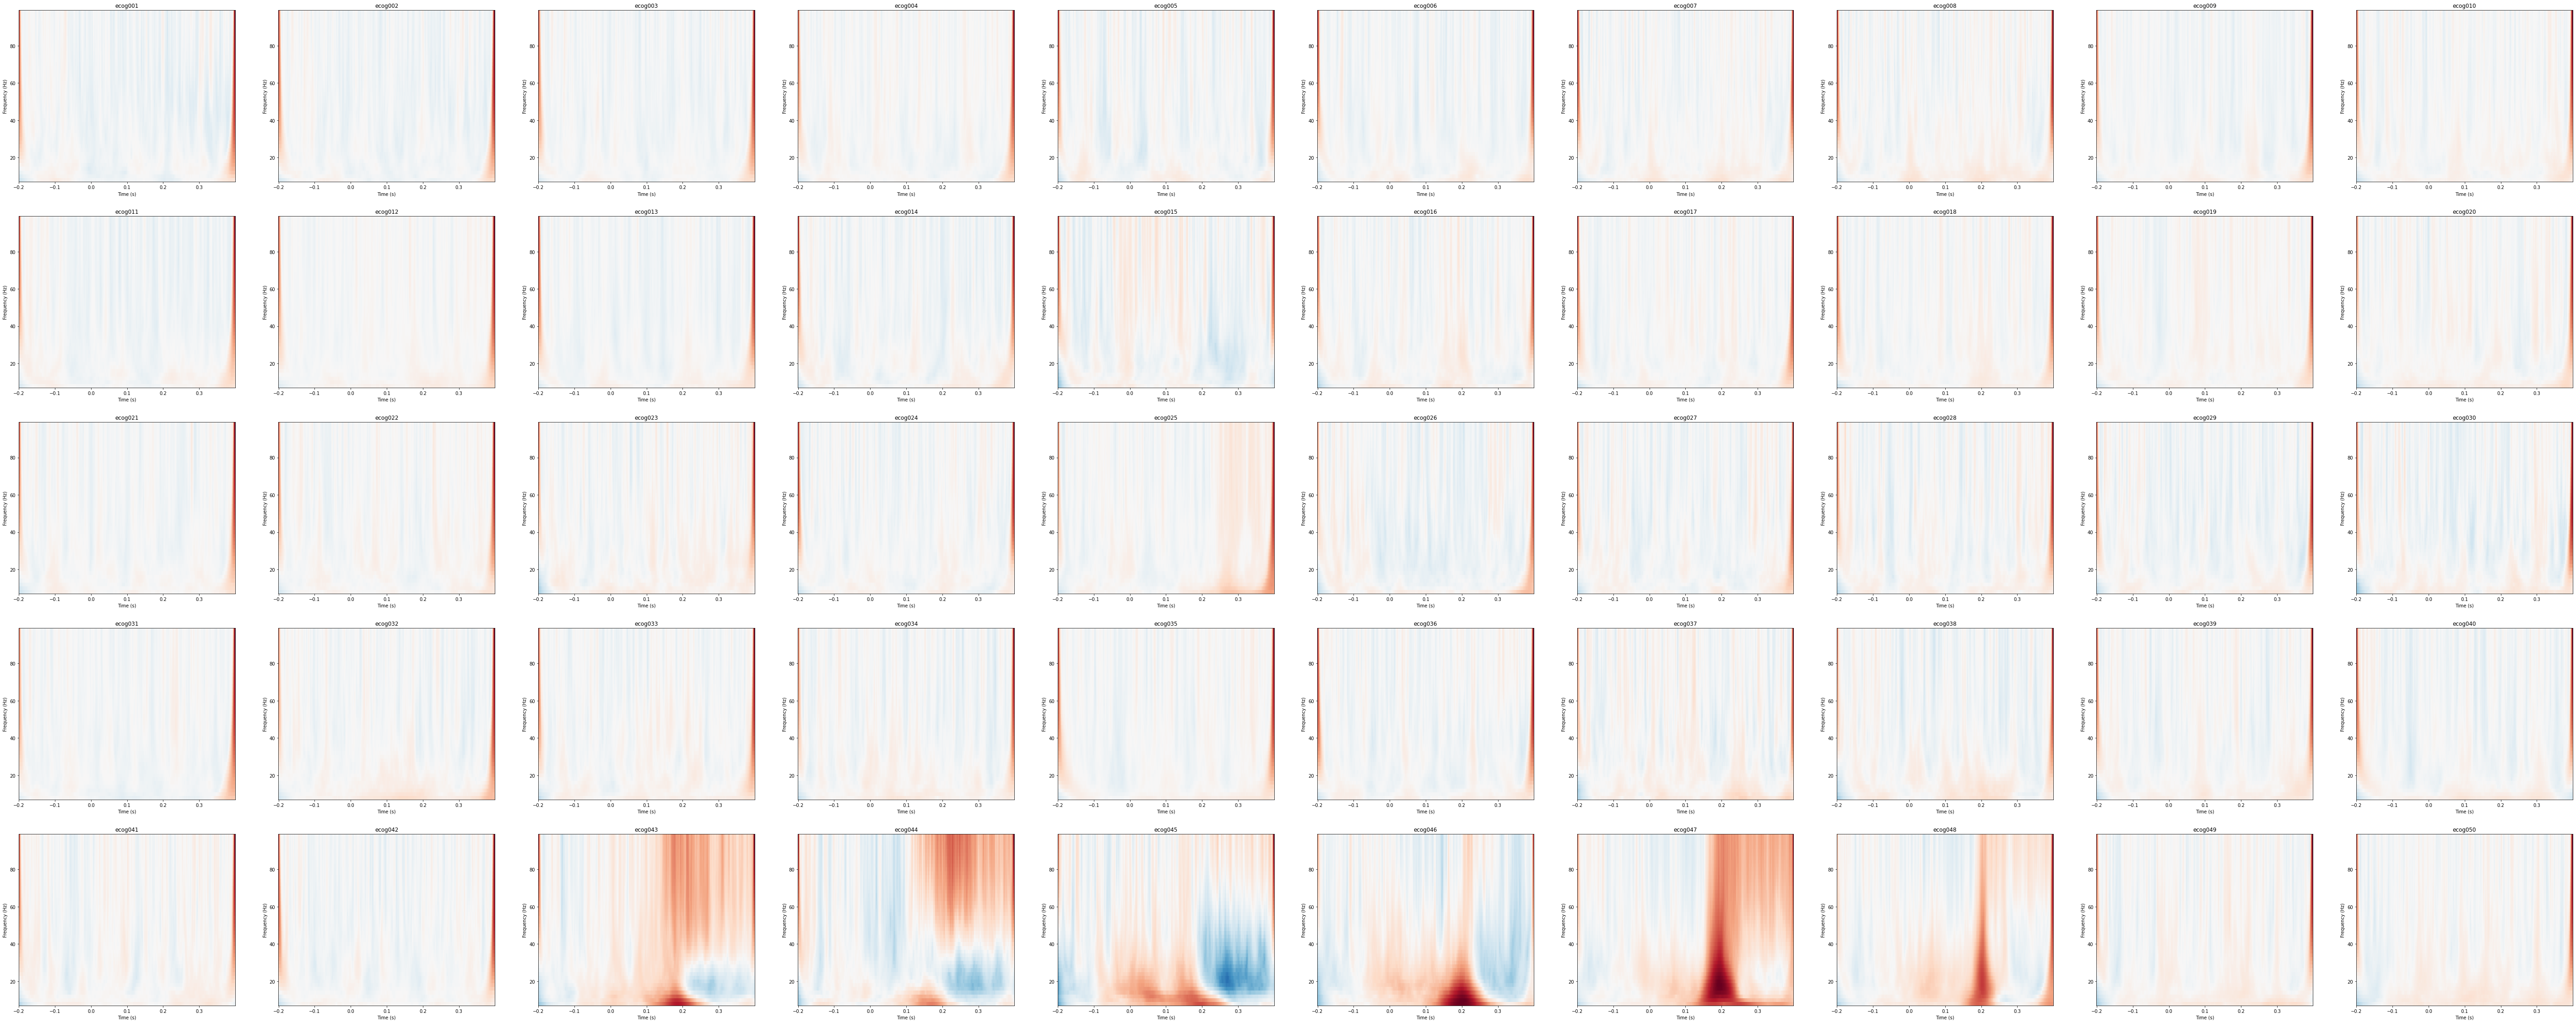

In [ ]:
logpowface_avg = logpowface.average()

fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(100, 40))
a=[]

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        a.append(ax)

for i, ax in enumerate(a):
    logpowface_avg.plot([i], baseline=(-0.2, 0), mode='mean', axes=ax, show=False, colorbar=False,) 
    ax.set_title(logpowface.ch_names[i])

In [ ]:
# reshape logpow
logpowface_t = logpowface.data.transpose((0,2,3,1))
logpowhouse_t = logpowhouse.data.transpose((0,2,3,1))


((150, 46, 600, 50), (150, 46, 600, 50))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


np.savez('/content/drive/My Drive/cnn_ecog_tfr.npz', logpowface_t, logpowface, logpowhouse_t, logpowhouse)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
